# Исследование успешности компьютерных игр

**Цель исследования** 

Определить наиболее перспективные платформы и жанры для продажи игр.

Проверить гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
2. Средние пользовательские рейтинги жанров Action и Sports разные. 

**Ход исследования**

 1. Обзор данных для определения их качества и основных проблем.
 2. Предобработка данных: обработка пропусков и дубликатов, создание вспомогательных столбцов.
 3. Исследовательский анализ: определение актуального периода и факторов, влияющих на продажи.
 4. Формирование портрета пользователя для разных регионов.
 5. Проверка гипотез.

## Обзор данных

In [1]:
# импорт необходимых библиотек
import warnings 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st

In [2]:
# убираем предупреждения
warnings.filterwarnings('ignore') 

Посмотрим на имеющиеся данные и общую информацию о них:

In [3]:
try:
    data = pd.read_csv('games.csv')
    
except:
    data = pd.read_csv('/datasets/games.csv')
    
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Столбцы, хранящие информацию с оценками критиков и пользоваелей, а также с рейтингом содержат большое число пропусков**. Небольшое количество пропусков есть и в столбцах с названием, жанром и годом релиза. Помимо этого **столбец с годом релиза имеет вещественный тип, вместо целочисленного**, а столбец с **оценками пользователей** вообще по каким-то причинам имеет тип данных **'object'**. Также для удобств работы **стоит привести названия столбцов к нижнему регистру**.

## Подготовка данных

Для начала переименуем столбцы:

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Посмотрим на долю пропусков в разных столбцах:

In [6]:
pd.DataFrame(round(data.isna().mean()*100, 4)).style.background_gradient('coolwarm')

,0
name,0.012000
platform,0.000000
year_of_release,1.609300
genre,0.012000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.319200
user_score,40.089700


**Пропусков в столбцах с названием, жанром и годом релиза очень мало** (менее 5% от общего объёма данных), **удалим их, и поменяем тип данных для столбца с годом релиза** на целочисленный:

In [7]:
# удаляем строки с пропусками в столбцах 'name','genre', 'year_of_release' и обновляем индексы в датафрейме
data = data.dropna(subset=['name', 'genre', 'year_of_release']).reset_index(drop=True)

In [8]:
# меняем тип данных для столбца с годом релиза
data['year_of_release'] = data['year_of_release'].astype(int) 

Посмотрим на **уникальные значения в столбце с оценками пользователей**:

In [9]:
data['user_score'].sort_values().unique() 

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

**Среди оценок имеется аббревиатура 'tbd'**, которая обычно расшифровывается как **'to be determined' (будет определена)**. В сущности, **можем рассматривать** эти значения **как пропуски**. 

In [10]:
# заменяем значения 'tbd' на пропуски
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan 

Теперь **можем сменить тип данных** данного столбца **на float**, чтобы иметь возможность обработать пропуски в данном столбце:

In [11]:
data['user_score'] = data['user_score'].astype(float)

**Пропуски в столбцах с оценками и рейтингом частично могут быть связаны с годом выпуска**. Едва ли система оценивания, тем более критиками была развита на заре компьютерных игр, а ESRB вообще была основана лишь в 1994 году. Посмотрим, действительно ли это так.  

In [12]:
# создаём сводные таблицы, содержащие общее число игр, число оценок критиков и пользователей и рейтинг игр по годам
stat_score = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
count_critic = data.pivot_table(index='year_of_release', values='critic_score', aggfunc='count')
count_user = data.pivot_table(index='year_of_release', values='user_score', aggfunc='count')
count_rating = data.pivot_table(index='year_of_release', values='rating', aggfunc='count')

# объединяем в общую сводную таблицу
stat_score = stat_score.join([count_critic, count_user, count_rating]) 

# переименовываем столбцы
stat_score.columns = ['count', 'count_critic', 'count_user', 'count_rating'] 

# добавляем столбцы, содержащие долю оценённых игр и получивших рейтинг
stat_score['share_critic'] = stat_score['count_critic'] / stat_score['count']
stat_score['share_user'] = stat_score['count_user'] / stat_score['count']
stat_score['share_rating'] = stat_score['count_rating'] / stat_score['count']

stat_score

,count,count_critic,count_user,count_rating,share_critic,share_user,share_rating
year_of_release,,,,,,,
1980,9,0,0,0,0.000000,0.000000,0.000000
1981,46,0,0,0,0.000000,0.000000,0.000000
1982,36,0,0,0,0.000000,0.000000,0.000000
1983,17,0,0,0,0.000000,0.000000,0.000000
1984,14,0,0,0,0.000000,0.000000,0.000000
1985,14,1,1,1,0.071429,0.071429,0.071429
1986,21,0,0,0,0.000000,0.000000,0.000000
1987,16,0,0,0,0.000000,0.000000,0.000000
1988,15,1,1,1,0.066667,0.066667,0.066667


Несмотря на то, что доля пропусков в ранние года действительно крайне высока, **к интересующему нас моменту их всё ещё достаточно много - около 50%**, но их **заполнение** даже медианным значением, **может привести к искажению результатов** исследования. Поэтому **пропуски в столбцах с оценками критиков и пользователей трогать не будем, а пропуски в столбце с рейтингами заменим на значение "unrating"**.

In [13]:
data['rating'] = data['rating'].fillna('unrating')

**Проверим наличие явных дубликатов:**

In [14]:
data.duplicated().sum() 

0

**Явных дубликатов нет.** 

Для дальнейшей работы нам потребуются **данные о суммарных продажах** во всех регионах, **создадим столбец *'total_sales'***, который будет хранить эту информацию:

In [15]:
data['total_sales'] = data[['na_sales', 'jp_sales', 'eu_sales', 'other_sales']].sum(axis=1) 

## Исследовательский анализ данных

Посмотрим на **динамику выпуска игр по годам**:

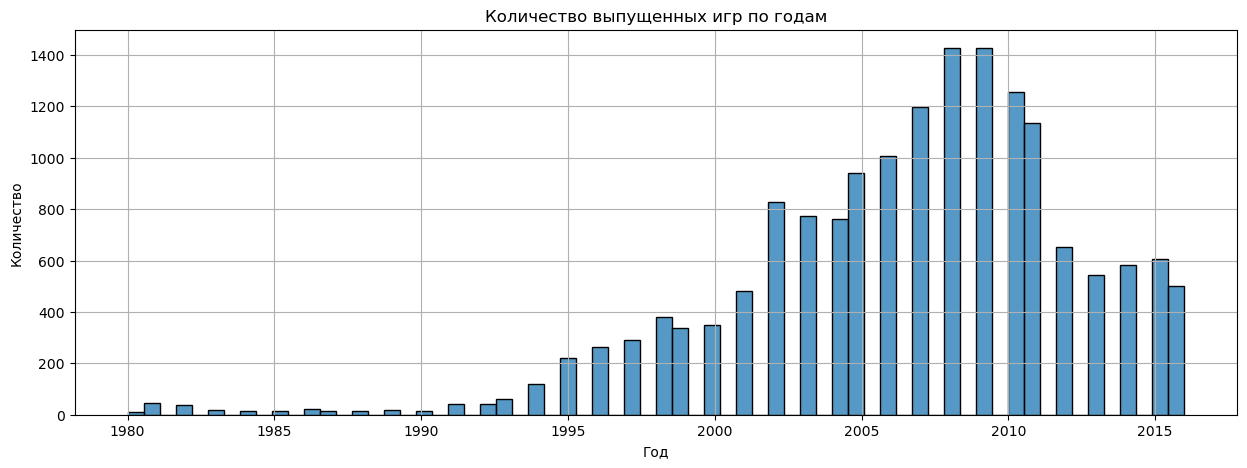

In [16]:
# построение гистограммы
plt.figure(figsize=(15, 5))

sns.histplot(data['year_of_release']) 
plt.title('Количество выпущенных игр по годам')
plt.ylabel('Количество')
plt.xlabel('Год')
plt.grid(True);

Число игр, выпущенных до 1995 года исчезающе мало. **Основная масса данных приходится на период 2000-2016 гг**. При этом **число выпускаемых игр, начиная с 2011 года, упало почти в 2 раза** в сравнении с пиковыми значениями.

### Изменение продаж по платформам

Посмотрим на платформы с наибольшим числом продаж:

In [17]:
# создание сводной таблицы суммарных продаж по платформам, сортировка по убыванию и вывод 10 первых строк
(data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
     .sort_values(by='total_sales', ascending=False)
     .head(10))

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


**Лидерами продаж** среди платформ являются **PS2, X360, PS3, Wii, DS и PS**. Посмотрим на изменение числа продаж для этих платформ по годам.

### Определение времени жизни платформы

In [18]:
# создание сводных таблиц с данными о суммарных продажах по годам для выбранных платформ
ps2_sales = data.query('platform == "PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
x360_sales = data.query('platform == "X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
ps3_sales = data.query('platform == "PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
wii_sales = data.query('platform == "Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
ds_sales = data.query('platform == "DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
ps_sales = data.query('platform == "PS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')

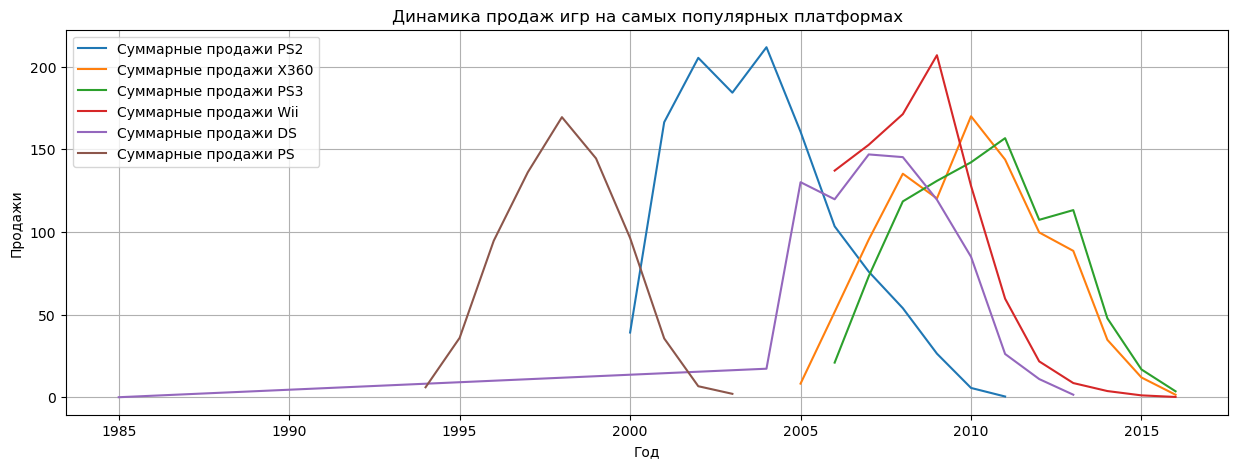

In [19]:
# построение графиков изменения суммарных продаж по годам для выбранных платформ
plt.figure(figsize=(15, 5))

plt.plot(ps2_sales, label='Суммарные продажи PS2')
plt.plot(x360_sales, label='Суммарные продажи X360')
plt.plot(ps3_sales, label='Суммарные продажи PS3')
plt.plot(wii_sales, label='Суммарные продажи Wii')
plt.plot(ds_sales, label='Суммарные продажи DS')
plt.plot(ps_sales, label='Суммарные продажи PS')

plt.title(label='Динамика продаж игр на самых популярных платформах')
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True)
plt.show();

По графикам видно, что **характерное время жизни платформ - 10 лет**. Немного выбивается DS, но и для неё основной объм продаж укладывается в 10 лет. В связи с этим для дальнейшего исследования **в качестве актуального периода выберем 5 лет** (половина жизни платформы), т.е. **период с 2012 по 2016 годы**.  

### Работа с данными за актуальный период

#### Определение лидеров продаж среди платформ

In [20]:
# сохраняем данные за актуальный период в переменную actual_data
actual_data = data.query('2012 <= year_of_release <= 2016')
# выводим размер получившегося среза
actual_data.shape  

(2886, 12)

В срез попало 2886 строк. **Посмотрим на лидеров продаж за этот период**:

In [21]:
# создание сводной таблицы суммарных продаж по платформам за 2012-2016 гг. 
sales_for_platform = actual_data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
# создаём столбец с жанром
sales_for_platform['platform'] = sales_for_platform.index 

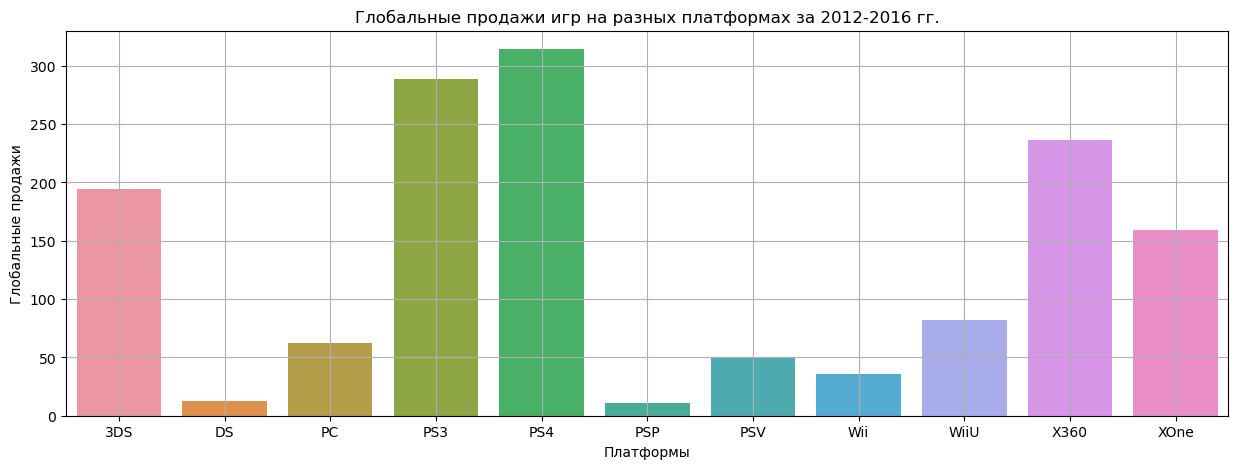

In [22]:
# построение столбчатой диаграммы для суммарных продаж по платформам за 2012-2016 гг. 
plt.figure(figsize=(15, 5))

sns.barplot(x=sales_for_platform['platform'], y=sales_for_platform['total_sales']) 
plt.title('Глобальные продажи игр на разных платформах за 2012-2016 гг.')
plt.ylabel('Глобальные продажи')
plt.xlabel('Платформы')
plt.grid(True);       

**Лидерами продаж за актуальный период явлются платформы PS4, PS3, X360, 3DS, XOne**, остальные существенно отстают от них. При этом уже видели, что **продажи на платформах PS3 и X360 к 2016 году упали практически до нуля.** То же можно сказать и о Wii и DS. **Визуализируем динамику продаж для оставшихся семи платформ**.

In [23]:
# создание сводных таблиц с данными о суммарных продажах за период 2012-2016 гг. для выбранных платформ
ps4_sales = actual_data.query('platform == "PS4"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
sales_3ds = actual_data.query('platform == "3DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
wiiu_sales = actual_data.query('platform == "WiiU"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
xone_sales = actual_data.query('platform == "XOne"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
pc_sales = actual_data.query('platform == "PC"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
psv_sales = actual_data.query('platform == "PSV"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
psp_sales = actual_data.query('platform == "PSP"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')

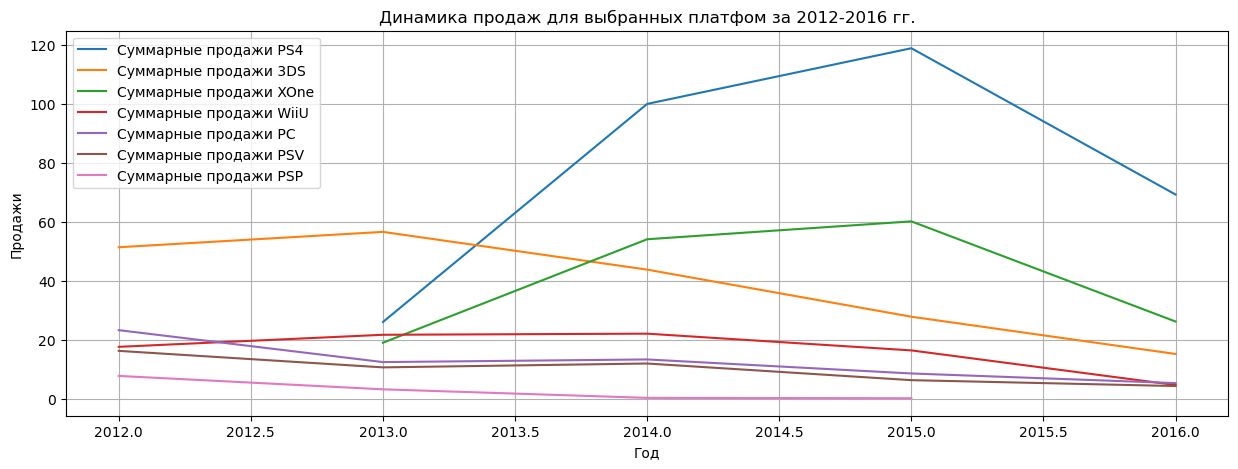

In [24]:
# построение графиков изменения суммарных продаж за период 2012-2016 гг. для выбранных платформ
plt.figure(figsize=(15, 5))

plt.plot(ps4_sales, label='Суммарные продажи PS4')
plt.plot(sales_3ds, label='Суммарные продажи 3DS')
plt.plot(xone_sales, label='Суммарные продажи XOne')
plt.plot(wiiu_sales, label='Суммарные продажи WiiU')
plt.plot(pc_sales, label='Суммарные продажи PC')
plt.plot(psv_sales, label='Суммарные продажи PSV')
plt.plot(psp_sales, label='Суммарные продажи PSP')

plt.title(label='Динамика продаж для выбранных платфом за 2012-2016 гг.')
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True)
plt.show();

**Для всех** рассматриваемых платформ **наблюдается спад числа продаж**. При этом **PS4 и XOne** находятся **в середине своего цикла жизни и являются лидерами продаж на 2016 год**. Стоит обратить внимание и на **3DS** - несмотря на **более низкие общие показатели, спад числа продаж не такой резкий**, как для PS4 и XOne, что **может привести со временем к выравниванию этих показетелей для всех трёх платформ**. Посмотрим на **разброс глобальных продаж для этих платформ**:

In [25]:
# срез данных за актуальный период 2012-2016 гг. для платформ PS4, XOne и 3DS 
actual_platform = actual_data.query('(platform == "PS4") or (platform == "XOne") or (platform == "3DS")')

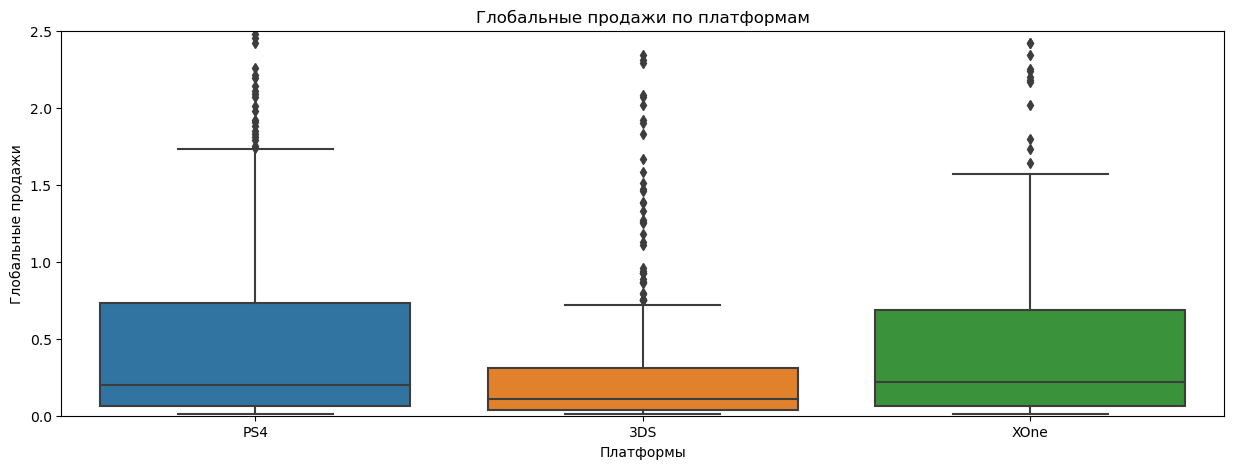

In [26]:
# построение диаграмм размаха глобальных продаж для платформ PS4, XOne и 3DS за 2012-2016 гг.
plt.figure(figsize=(15, 5))

(sns.boxplot(data=actual_platform, y='total_sales', x='platform')
    .set(title='Глобальные продажи по платформам', xlabel='Платформы', ylabel='Глобальные продажи'))

plt.ylim(0, 2.5);

**3DS сильно уступает PS4 и XOne**, как по медианному значению глобальных продаж, так и в целом по их разбросу. **PS4 и XOne достаточно похожи**. При этом **медианное значение продаж у XOne немного выше**, в то время как **у PS4 несколько выше межквартильный размах**. Таким образом, **самой перспективной платформой для релиза новых игр является PS4, немного ей уступает XOne**.

#### Влияние оценок критиков и пользователей на продажи

Посмотрим, **как влияют отзывы критиков и пользователей на продажи внутри перспективных платформ**:

In [27]:
# срезы данных по платформам
actual_data_ps4 = actual_data.query('platform == "PS4"') 
actual_data_xone = actual_data.query('platform == "XOne"')
actual_data_3ds = actual_data.query('platform == "3DS"')

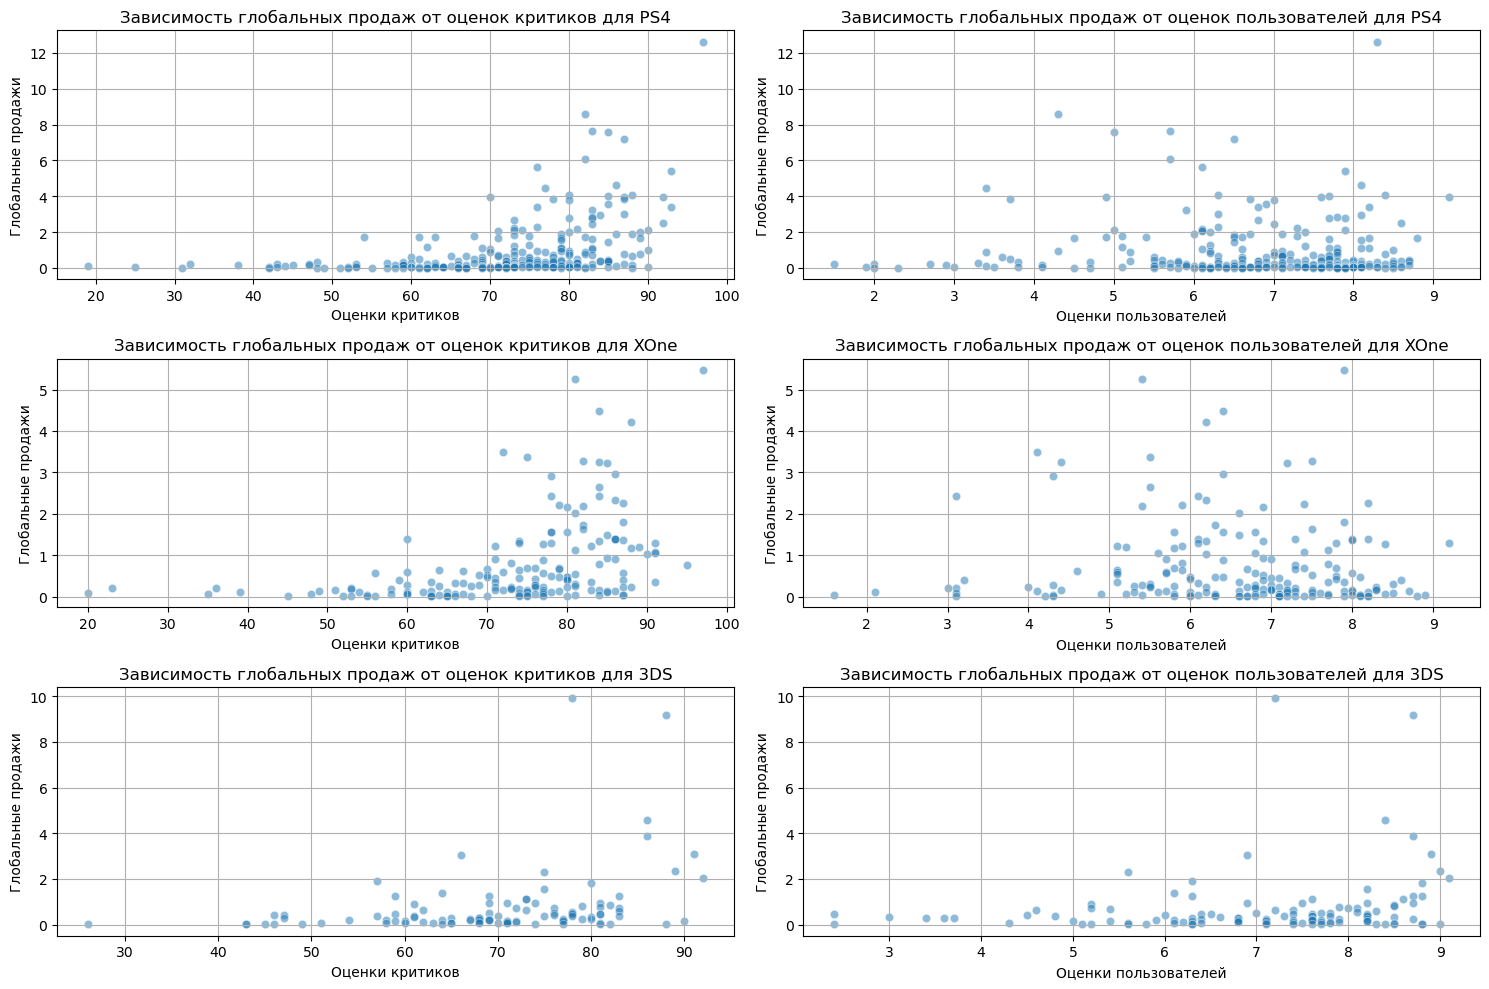

In [28]:
# построение диаграмм рассеяния
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(321)
sns.scatterplot(data=actual_data_ps4, x='critic_score', y='total_sales', alpha=0.5) 
plt.title('Зависимость глобальных продаж от оценок критиков для PS4')
plt.xlabel('Оценки критиков')
plt.ylabel('Глобальные продажи')
plt.grid(True)

fig.add_subplot(322)
sns.scatterplot(data=actual_data_ps4, x='user_score', y='total_sales', alpha=0.5) 
plt.title('Зависимость глобальных продаж от оценок пользователей для PS4')
plt.xlabel('Оценки пользователей')
plt.ylabel('Глобальные продажи')
plt.grid(True)

fig.add_subplot(323)
sns.scatterplot(data=actual_data_xone, x='critic_score', y='total_sales', alpha=0.5) 
plt.title('Зависимость глобальных продаж от оценок критиков для XOne')
plt.xlabel('Оценки критиков')
plt.ylabel('Глобальные продажи')
plt.grid(True)

fig.add_subplot(324)
sns.scatterplot(data=actual_data_xone, x='user_score', y='total_sales', alpha=0.5) 
plt.title('Зависимость глобальных продаж от оценок пользователей для XOne')
plt.xlabel('Оценки пользователей')
plt.ylabel('Глобальные продажи')
plt.grid(True)

fig.add_subplot(325)
sns.scatterplot(data=actual_data_3ds, x='critic_score', y='total_sales', alpha=0.5)
plt.title('Зависимость глобальных продаж от оценок критиков для 3DS')
plt.xlabel('Оценки критиков')
plt.ylabel('Глобальные продажи')
plt.grid(True)

fig.add_subplot(326)
sns.scatterplot(data=actual_data_3ds, x='user_score', y='total_sales', alpha=0.5) 
plt.title('Зависимость глобальных продаж от оценок пользователей для 3DS')
plt.xlabel('Оценки пользователей')
plt.ylabel('Глобальные продажи')
plt.grid(True)

plt.tight_layout()
plt.show();

Также рассчитаем **коэффициенты корреляции Пирсона**: 

In [29]:
print('Коэффициент корреляции глобальных продаж с оценками критиков', '\n')
print('PS4:', round(actual_data_ps4['total_sales'].corr(actual_data_ps4['critic_score']), 2))
print('XOne:', round(actual_data_xone['total_sales'].corr(actual_data_xone['critic_score']), 2))
print('3DS:', round(actual_data_3ds['total_sales'].corr(actual_data_3ds['critic_score']), 2))

Коэффициент корреляции глобальных продаж с оценками критиков 

PS4: 0.41
XOne: 0.42
3DS: 0.32


In [30]:
print('Коэффициент корреляции глобальных продаж с оценками пользователей', '\n')
print('PS4:', round(actual_data_ps4['total_sales'].corr(actual_data_ps4['user_score']), 2))
print('XOne:', round(actual_data_xone['total_sales'].corr(actual_data_xone['user_score']), 2))
print('3DS:', round(actual_data_3ds['total_sales'].corr(actual_data_3ds['user_score']), 2))

Коэффициент корреляции глобальных продаж с оценками пользователей 

PS4: -0.03
XOne: -0.07
3DS: 0.2


**Линейной зависимости между глобальными продажами и оценками пользователей нет**, об этом говорит и коэффициент Пирсона почти равный нулю, и вид диаграммы рассеяния. **Между оценками критиков и глобальными продажами также нет сильной корреляции, но она намного более выраженная** (коэффициент Пирсона 0.3-0.4). Некоторые отличия для 3DS связаны, скорее всего, с заметно меньшим объёмам данных по этой платформе.

#### Влияние жанра игры на продажи

Посмотрим, как влияет жанр игр на их продажи:

In [31]:
# создание сводной таблицы суммарных продаж по жанрам за 2012-2016 гг. 
sales_for_genre = actual_data.pivot_table(index='genre', values='total_sales', aggfunc='sum')

# создаём столбец с жанром  
sales_for_genre['genre'] = sales_for_genre.index 

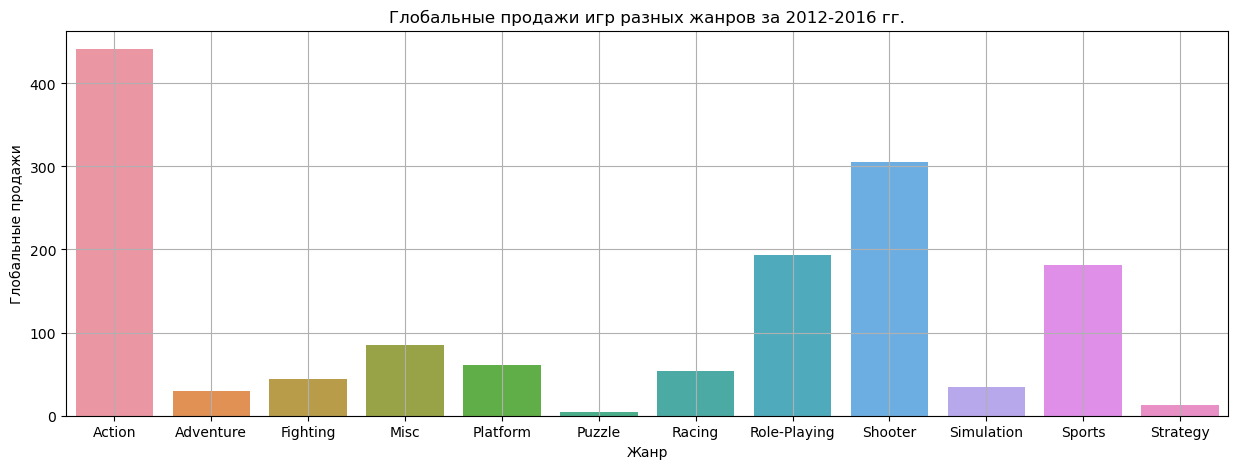

In [32]:
# построение столбчатой диаграммы для суммарных продаж по жанрам за 2012-2016 гг.
plt.figure(figsize=(15, 5))

sns.barplot(x=sales_for_genre['genre'], y=sales_for_genre['total_sales']) 
plt.title('Глобальные продажи игр разных жанров за 2012-2016 гг.')
plt.ylabel('Глобальные продажи')
plt.xlabel('Жанр')
plt.grid(True);             

**Самыми прибыльными являются игры в жанрах Action. Также выделяются продажи игр в жанрах Shooter, Role-Playing и Sports**. Особенно низкие показатели продаж среди жанров Puzzele и Strategy. Высокие показатели отдельных жанров могут быть связаны с совокупным числом выпускаемых игр данного жанра:

In [33]:
# создание сводной таблицы с числом выпускаемых игр разных жанров за 2012-2016 гг. 
genre = actual_data.pivot_table(index='genre', values='name', aggfunc=('count'))

# создаём столбец с жанром
genre['genre'] = genre.index 

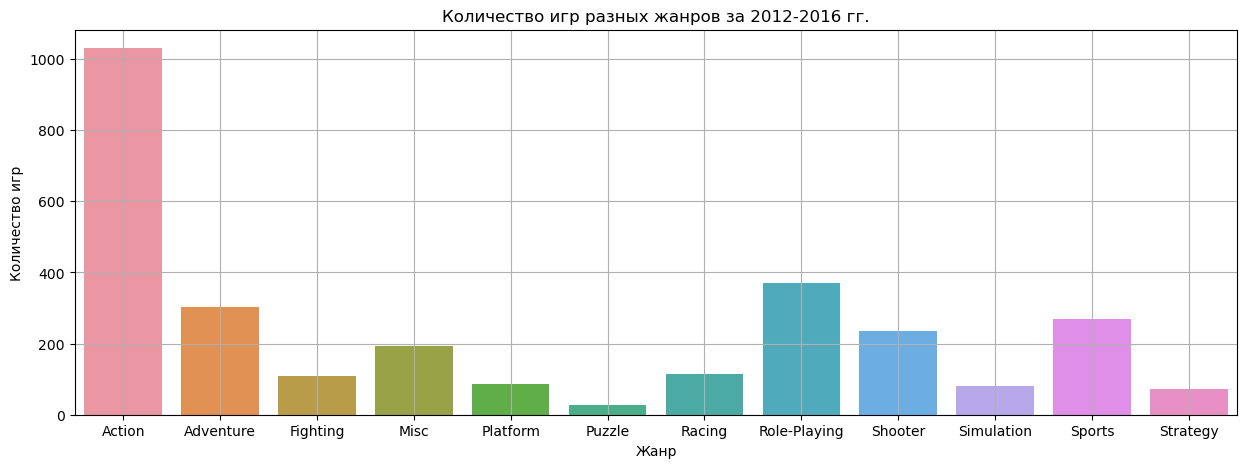

In [34]:
# построение столбчатой диаграммы для числа выпускаемых игр разных жанров за 2012-2016 гг.
plt.figure(figsize=(15, 5))

sns.barplot(x=genre['genre'], y=genre['name']) 
plt.title('Количество игр разных жанров за 2012-2016 гг.')
plt.ylabel('Количество игр')
plt.xlabel('Жанр')
plt.grid(True);             

Действительно, **если сравнивать глобальные продажи игр определённого жанра с число выпускаемых игр, наблюдается сходство**. Наиболее сильно из него выпадает жанр Adventure - несмотря на немалое число игр этого жанра, показатели продаж у него довольно маленькие.

**Посмотрим также на медианные продажи**, чтобы понять сколько обычно приносит игра каждого жанра:

In [35]:
# создание сводной таблицы с числом выпускаемых игр разных жанров за 2012-2016 гг. 
genre_median_sales = actual_data.pivot_table(index='genre', values='total_sales', aggfunc='median')
# создаём столбец с жанром
genre_median_sales['genre'] = genre_median_sales.index 

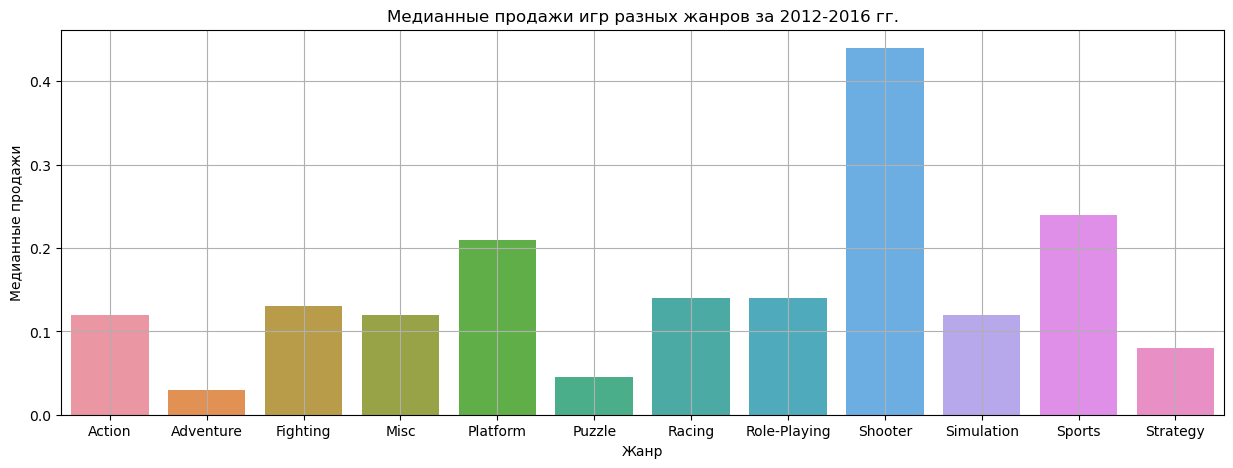

In [36]:
# построение столбчатой диаграммы для числа выпускаемых игр разных жанров за 2012-2016 гг.
plt.figure(figsize=(15, 5))

sns.barplot(x=genre_median_sales['genre'], y=genre_median_sales['total_sales']) 
plt.title('Медианные продажи игр разных жанров за 2012-2016 гг.')
plt.ylabel('Медианные продажи')
plt.xlabel('Жанр')
plt.grid(True);             

Здесь картина разительно отличается. **Наиболее высокие стабильные продажи имеют шутеры, также выделяются платформеры и спортивные игры, в то время как жанр Action ничем не выделяется**.

## Составление портретов пользователей по регионам

### Предпочтительные платформы

Для начала определим, каким платформам отдают предпочтение пользователи разных регионов.

In [37]:
# создание сводной таблицы с продажами за 2012-2016 гг. на разных платформах в разных регионах
region_actual_platform = actual_data.pivot_table(columns='platform', 
                                                 values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
region_actual_platform

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
eu_sales,42.64,3.53,37.76,106.86,141.09,0.42,11.36,11.92,25.13,74.52,51.59
jp_sales,87.79,3.72,0.00,35.29,15.96,10.47,21.04,3.39,13.01,1.57,0.34
na_sales,55.31,4.59,19.12,103.38,108.74,0.13,10.98,17.45,38.10,140.05,93.12


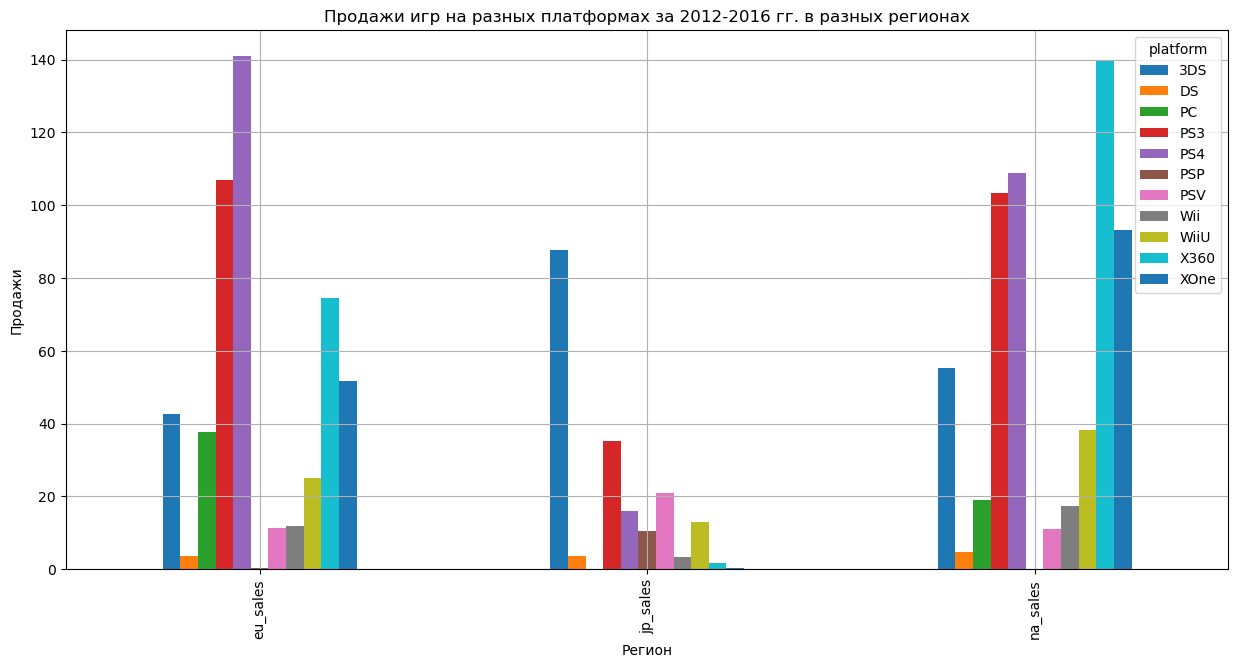

In [38]:
# построение столбчатой диаграммы для продаж в разных регионах по платформам за 2012-2016 гг. 
region_actual_platform.plot(kind='bar', figsize=(15, 7), grid=True, 
                     title='Продажи игр на разных платформах за 2012-2016 гг. в разных регионах', 
                     ylabel='Продажи', xlabel='Регион');

**Топ-5 платформ в европейском и северо-американском регионах совпадает - 3DS, PS3, PS4, X360, XOne**, хотя внутри топа распределения несколько отличаются. Так **пользователи из Северной Америки отдают большее предпочтение приставкам от Microsoft (X360, XOne), в то время как европейцы - от Sony (PS3, PS4)**.

В то же время предпочтения пользователей из Японии значительно отличаются. **Абсолютным лидером продаж в этом регионе является 3DS от Nintendo**. Помимо этого можно также выделить PS3 и PSV, показатели PS4, WiiU и PSP практически одинаковы, а для остальных платформ стремятся к нулю. Помимо этого, **число продаж в Японии в целом меньше, чем в Северной Америке и Европе**. 

### Популярные жанры

Посмотрим как отличаются жанровые предпочтения в разных регионах:

In [39]:
# создание сводной таблицы с продажами за 2012-2016 гг. игр разных жанров в разных регионах
region_actual_genre = actual_data.pivot_table(columns='genre', 
                                              values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

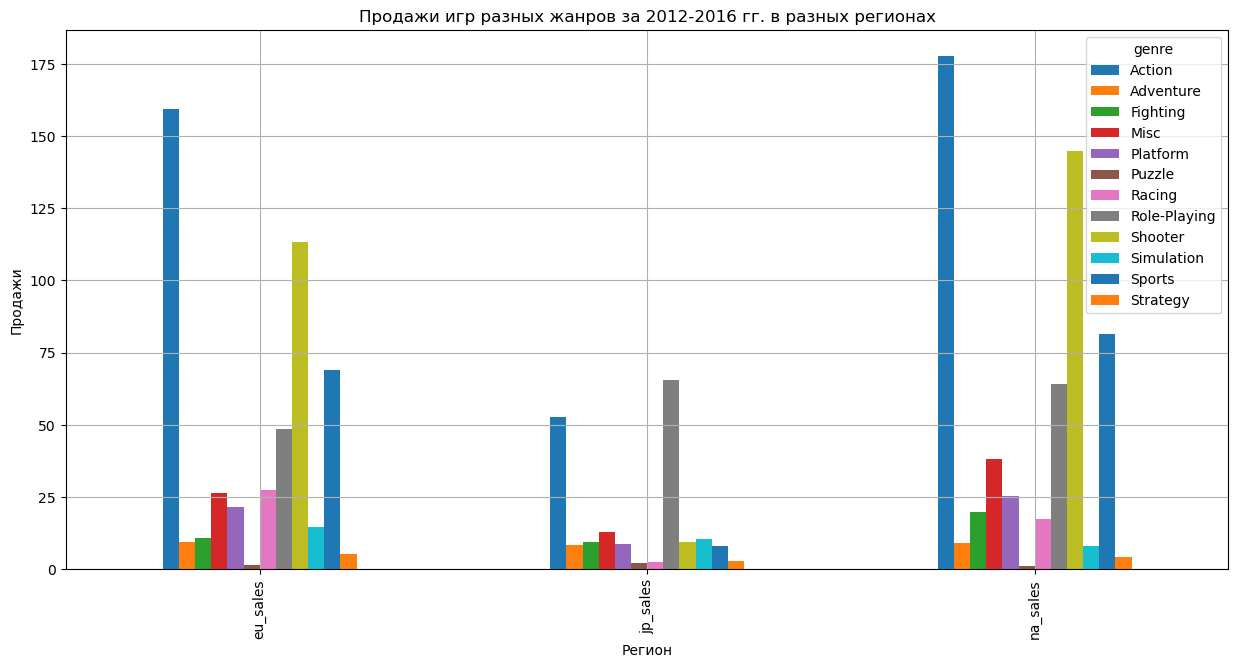

In [40]:
# построение столбчатой диаграммы для продаж в разных регионах игр разных жанров за 2012-2016 гг. 
region_actual_genre.plot(kind='bar', figsize=(15, 7), grid=True,
                     title='Продажи игр разных жанров за 2012-2016 гг. в разных регионах', 
                     ylabel='Продажи', xlabel='Регион');

**Жанровые предпочтения пользователей из Европы и Северной Америки практически идентичны. Наиболее популярны** здесь игры в жанрах **Action, Shooter, Sports и Role-Playing**. Также можно отметить жанр Misc и, для европейцев, Racing.

**Японские пользователи наибольшее предпочтение отдают жанрам Role-Playing и Action**. Очень **высокие показатели для жанра RPG связан** не столько с классическими RPG, а скорее **с поджанром JRPG, который изначально создавался для японской аудитории**. Нельзя сказать, что японцы отдают явное предпочтение какому-либо из оставшихся жанров. 

### Влияние рейтинга ESRB на продажи

In [41]:
# создание сводной таблицы с продажами за 2012-2016 гг. игр с разным рейтингом в разных регионах
region_actual_rating = actual_data.pivot_table(columns='rating', 
                                               values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

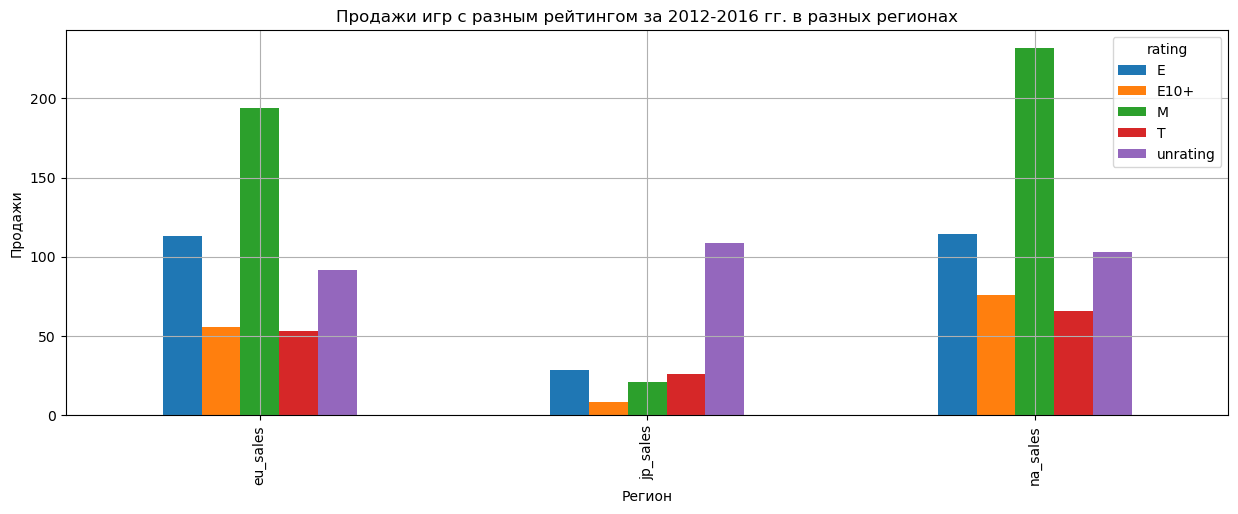

In [42]:
# построение столбчатой диаграммы для продаж в разных регионах игр с разным рейтингом за 2012-2016 гг. 
region_actual_rating.plot(kind='bar', figsize=(15, 5), grid=True,
                     title='Продажи игр с разным рейтингом за 2012-2016 гг. в разных регионах', 
                     ylabel='Продажи', xlabel='Регион');

Как и ранее, **предпочтения европейских и северо-американских пользователей очень похожи**. Наибольшие продажи для них наблюдаются среди игр **категории M (для взрослых) и E (для всех)**. **В Японии продажи игр рейтинга М тоже высоки, но уступают играм рейтингов Е и Т (для подростков)**. Помимо этого стоит отметить, что в Японии очень высока доля игр без рейтинга, что, скорее всего, сильно искажает данные.

## Проверка гипотез

### Гипотеза: **cредние пользовательские рейтинги платформ Xbox One и PC одинаковые**


Прежде, чем проверять гипотезу, подготовим актуальные выборки для XOne и PC:

In [43]:
# срез данных с актуальной информацией по XOne и удаление строк с пропусками в столбце с пользовательскими оценками
xone_st = actual_data.query('platform == "XOne"').dropna(subset=['user_score'])

# смотрим размер выборки
xone_st.shape 

(182, 12)

In [44]:
# срез данных с актуальной информацией по PC и удаление строк с пропусками в столбце с пользовательскими оценками
pc_st = actual_data.query('platform == "PC"').dropna(subset=['user_score'])
pc_st.shape # смотрим размер выборки

(206, 12)

**Нулевая гипотеза (H_0) формулируется через равенство**, и в данном случае **совпадает с исходной гипотезой**, а так как нас не интересует больше или меньше средние пользовательские оценки для одной из платформ, то **альтернативная гипотеза (H_a) будет двухсторонней**: 

```
H_0: Средние пользовательские рейтинги "XOne" = средние пользовательские рейтинги "PC"`
H_a: Средние пользовательские рейтинги "XOne" ≠ средние пользовательские рейтинги "PC"`

```
**Уровень значимости** зададим в **5%** (alpha = 0.05). 

In [45]:
# проверка гипотезы
results = st.ttest_ind(xone_st['user_score'], pc_st['user_score'], equal_var=False)

# вывод значения p-value на экран 
print('p-value =', results.pvalue) 

p-value = 0.5489537965134912


Полученное p-value больше выбранного значения статистической значимости, значит, **не можем отвергнуть нулевую гипотезу о равенстве средних пользовательских оценок XOne и PC**.   

### Гипотеза: cредние пользовательские рейтинги жанров Action и Sports разные

Подготовим актуальные выборки для жанров "Action" и "Sports":

In [46]:
# срез данных с актуальной информацией по жанру "Action" и удаление строк с пропусками в столбце с пользовательскими оценками
action_st = actual_data.query('genre == "Action"').dropna(subset=['user_score'])

# смотрим размер выборки
action_st.shape 

(523, 12)

In [47]:
# срез данных с актуальной информацией по жанру "Sports" и удаление строк с пропусками в столбце с пользовательскими оценками
sports_st = actual_data.query('genre == "Sports"').dropna(subset=['user_score'])

# смотрим размер выборки
sports_st.shape 

(195, 12)

В данном случае **нулевая гипотеза (H_0) не совпадает с исходной гипотезой**, а так как нас всё ещё не интересует больше или меньше средние пользовательские оценки для одного из жанров, то **альтернативная гипотеза (H_a) будет двухсторонней и будет совпадать с исходной**: 
 

```
H_0: Средние пользовательские рейтинги жанра "Action" = средние пользовательские рейтинги жанра "Sports"`
H_a: Средние пользовательские рейтинги жанра "Action" ≠ средние пользовательские рейтинги жанра "Sports"`

```
**Уровень значимости** зададим в **5%** (alpha = 0.05)

In [48]:
# проверка гипотезы
results = st.ttest_ind(action_st['user_score'], sports_st['user_score'], equal_var=False)

# вывод значения p-value на экран 
print('p-value =', results.pvalue) 

p-value = 4.24307776572644e-20


Полученное p-value меньше выбранного значения статистической значимости, значит, нулевую **гипотезу о равенстве средних пользовательских оценок жанров Action и Sports необходимо отвергнуть**, т.е. **принимаем альтернативную гипотезу**.

## Общий вывод

В ходе изучения данных было **обнаружено большое число пропусков**. В столбцах с оценками пользователей и критиков, а также рейтингом ESRB, которые было решено оставить, чтобы не исказить данные. Небольшое количество пропусков в столбцах с названием/жанром/годом релиза было удалено.

Анализ самых популярных платформ за всё время показал, что **среднее время жизни платформ - 10 лет**, поэтому **для дальнейшего иследования и составления прогноза на 2017 год были отобраны данные только за 2012-2016 годы**. 

Актуальные данные показали, что на 2016 год **все рассматриваемые платформы переживают спад продаж**. Среди них **наиболее перспективными являются PS4 и XOne** - обе находятся в середине своего жизненного цикла и имеют высокие продажи, при этом показатели PS4 несколько выше.

**Изучение факторов, влияющих на продажи игр на разных платформах**, показало:
1. Пользовательские оценки никак не коррелируют с продажами. 
2. Влияние оценок критиков заметно выше, но всё же нельзя говорить о сильной корреляции этих двух переменных. 
3. **Наиболее популярными** и, как следствие, прибыльными **оказался жанр Shooter**, также **довольно популярны игры в жанрах, Platform и Sports**.    

В ходе исследования **составлены портреты пользователей разных регионов**:
1. Пользователи Северной Америки и Европы очень похожи. И те, и другие, в целом, отдают предпочтение 3DS, PS3, PS4, X360, XOne. При этом **пользователи из Северной Америки в первую очередь выбирают приставки от Microsoft (X360, XOne), а европейцы - от Sony (PS3, PS4)**. И те, и другие **предпочитают игры в жанрах Action, Shooter, Sports и Role-Playing**. А среди рейтингов ESRB выделяются **категории M (для взрослых) и E (для всех)**.
2. Пользователи из Япониии имеют свои отличительные особенности. Среди платформ **абсолютным лидером в Японии является 3DS от Nintendo**. А **игры жанра Role-Playing соперничают и даже немного превосходят игры жанра Action**, что, вероятно, связано с играми поджанра JRPG изначально создававшимися под японскую аудиторию. **Говорить же о влиянии рейтинга ESRB в данном регионе довольно затруднительно**, поскольку **большая часть игр здесь его не имеет**.
3. Также можно отметить на то, что **продажи в Японии в целом ниже, чем в европейском и северо-американском регионах**, что по большей части связано с разницей в численности населения этих регионов. 

**Обе выдвинутые в начале гипотезы подтвердились**:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
2. Средние пользовательские рейтинги жанров Action и Sports разные.
